In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch 
from torchvision import datasets,transforms, models
from torch import optim , nn
from torch.utils.data import DataLoader
import torch.nn.functional as F 
import matplotlib.pyplot as plt


In [3]:
transforms = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),])

dataset = datasets.ImageFolder(root='gdrive/My Drive/seefood/train/',transform=transforms)
validation_set = datasets.ImageFolder(root='gdrive/My Drive/seefood/test/',transform=transforms)
dataset 

Dataset ImageFolder
    Number of datapoints: 498
    Root location: gdrive/My Drive/seefood/train/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [4]:
trainLoader = DataLoader(dataset, batch_size=20,shuffle= True)
valLoader = DataLoader(validation_set,batch_size=20,shuffle=True )

Text(0.5, 1.0, 'Label : 1')

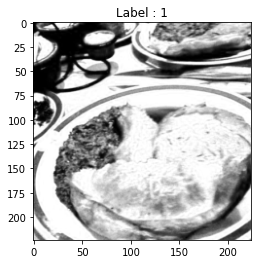

In [20]:
data = iter(trainLoader)
images ,labels = next(data)
plt.imshow(images[0][0,:,:],cmap='gray')
plt.title(f"Label : {labels[0]}")

In [6]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
print(torch.cuda.get_device_name(0))

Tesla K80


In [8]:
model = models.densenet121(pretrained=True)

In [9]:
for params in model.parameters():
  params.require_grad = False 

In [10]:
model.classifier 

Linear(in_features=1024, out_features=1000, bias=True)

In [11]:
classifier = nn.Sequential(nn.Linear(1024,1024),nn.ReLU(),nn.Dropout(p=0.3),
                           nn.Linear(1024,512),nn.ReLU(),nn.Dropout(p=0.3),
                           nn.Linear(512,2),nn.LogSoftmax(dim=1))
model.classifier = classifier
model.classifier 

Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=512, out_features=2, bias=True)
  (7): LogSoftmax(dim=1)
)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [13]:
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

In [14]:
loss_graph , val_loss_graph , acc = [] , [] , []
for _ in range(6):
  running_loss = 0
  val_loss = 0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.train()

  for images, labels in trainLoader:

    images , labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    logits = model(images)
    loss = loss_function(logits,labels )
    running_loss += loss.item()
    loss.backward()

    optimizer.step()

  with torch.no_grad(): 
    model.eval()
    cor = 0
    total = 0

    for images,labels in valLoader:
      images , labels = images.to(device), labels.to(device)
      predictions = model(images)
      loss = loss_function(predictions, labels)
      val_loss += loss.item()

      for p,l in zip(torch.argmax(predictions,dim=1 ),labels):
        if p==l:
          cor +=1
        total +=1 

  loss_graph.append(running_loss/len(trainLoader))
  val_loss_graph.append(val_loss/len(valLoader))
  acc.append(cor*100/total)
  print(f'training loss : {running_loss/len(trainLoader)} , validation loss : {val_loss/len(valLoader)} , Accuracy : {cor*100/total}')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


training loss : 0.8344280552864075 , validation loss : 0.38366479575634005 , Accuracy : 87.4
training loss : 0.3701903349161148 , validation loss : 0.4923225581645966 , Accuracy : 76.2
training loss : 0.40178473711013796 , validation loss : 0.26429639220237733 , Accuracy : 90.2
training loss : 0.29359916508197786 , validation loss : 0.2639751332998276 , Accuracy : 89.6
training loss : 0.23448901653289794 , validation loss : 0.26386004567146304 , Accuracy : 89.6
training loss : 0.20928374886512757 , validation loss : 0.3389912351965904 , Accuracy : 86.2


#### Results 

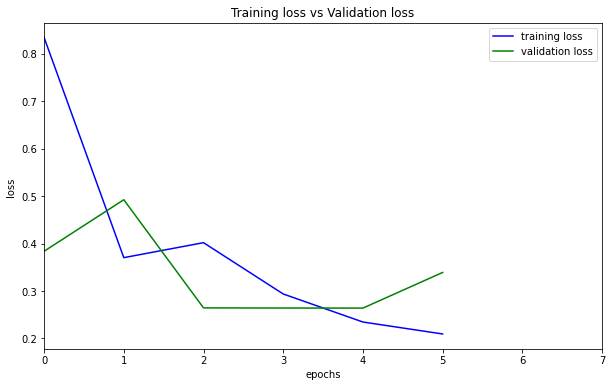

In [17]:
plt.figure(figsize=(10,6))
plt.plot(range(6),loss_graph,color = 'blue',label='training loss')
plt.plot(range(6),val_loss_graph,color = 'green', label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('loss ')
plt.xlim(0,7)
plt.title('Training loss vs Validation loss')
plt.legend()

Text(0.5, 1.0, 'Accuracy over epochs')

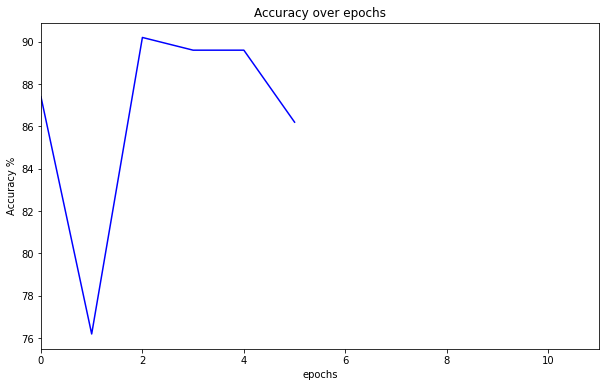

In [18]:
plt.figure(figsize=(10,6))
plt.plot(range(6),acc,color = 'blue')
plt.xlabel('epochs')
plt.ylabel('Accuracy %')
plt.xlim(0,11)
plt.title('Accuracy over epochs')

In [30]:
classes = {0:'hot dog', 1:'not hot dog'}

'hot dog'

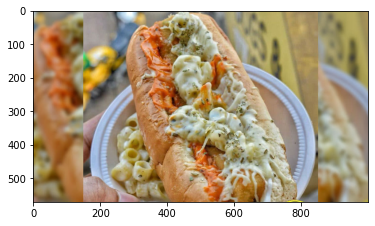

In [31]:
from PIL import Image
import requests 

url = 'https://res.cloudinary.com/purnesh/image/upload/w_1000,f_auto,q_auto:eco,c_limit/hot-dog148.jpg'

response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

img_t = transforms(img)  
output = model(img_t.unsqueeze(0).to(device))
prediction = torch.argmax(output,dim=1)
classes[prediction.item()] 

In [34]:
torch.save(model.state_dict(),'seefood89.pth')